In [1]:
from warnings import filterwarnings
filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import radians, cos, sin, sqrt, asin
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import pandas as pd


In [2]:
plt.rcParams['figure.figsize'] = [15,8]

In [ ]:
#set options
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.float_format = '{:.6f}'.format

In [3]:
x=pd.read_csv("C:/Users/hemap/Downloads/TaxiFarePrediction/Taxi Fare Prediction/Dataset/TaxiFare.csv")
df=pd.DataFrame(x)
df


,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
49995,25:15.0,15.0,2013-06-12 23:25:15 UTC,-73.999973,40.748531,-74.016899,40.705993,1
49996,19:18.0,7.5,2015-06-22 17:19:18 UTC,-73.984756,40.768211,-73.987366,40.760597,1
49997,53:00.0,6.9,2011-01-30 04:53:00 UTC,-74.002698,40.739428,-73.998108,40.759483,1
49998,09:00.0,4.5,2012-11-06 07:09:00 UTC,-73.946062,40.777567,-73.953450,40.779687,2


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   unique_id             50000 non-null  object 
 1   amount                50000 non-null  float64
 2   date_time_of_pickup   50000 non-null  object 
 3   longitude_of_pickup   50000 non-null  float64
 4   latitude_of_pickup    50000 non-null  float64
 5   longitude_of_dropoff  50000 non-null  float64
 6   latitude_of_dropoff   50000 non-null  float64
 7   no_of_passenger       50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [5]:
df= df.drop('unique_id', axis = 1)

In [6]:
df.dtypes

amount                  float64
date_time_of_pickup      object
longitude_of_pickup     float64
latitude_of_pickup      float64
longitude_of_dropoff    float64
latitude_of_dropoff     float64
no_of_passenger           int64
dtype: object

In [11]:
#change object datatype
df.date_time_of_pickup = pd.to_datetime(df.date_time_of_pickup)

In [12]:
df.dtypes

amount                              float64
date_time_of_pickup     datetime64[ns, UTC]
longitude_of_pickup                 float64
latitude_of_pickup                  float64
longitude_of_dropoff                float64
latitude_of_dropoff                 float64
no_of_passenger                       int64
dtype: object

In [7]:
df.shape

(50000, 7)

In [8]:
df.describe()

,amount,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734372,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


In [9]:
df.isnull().sum()

amount                  0
date_time_of_pickup     0
longitude_of_pickup     0
latitude_of_pickup      0
longitude_of_dropoff    0
latitude_of_dropoff     0
no_of_passenger         0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [20]:
# extract various date time components as seperate variables
df= df.assign(hour = df.date_time_of_pickup.dt.hour, 
                         day = df.date_time_of_pickup.dt.day,
                        month = df.date_time_of_pickup.dt.month, 
                        year = df.date_time_of_pickup.dt.year, 
                        dayofweek = df.date_time_of_pickup.dt.dayofweek)

In [21]:
# function to calculate the travel distance from the longitudes and latitudes
def distance_transform(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []
    
    for pos in range(len(longitude1)):
        long1,lati1,long2,lati2 = map(radians,[longitude1[pos],latitude1[pos],longitude2[pos],latitude2[pos]])
        dist_long = long2 - long1
        dist_lati = lati2 - lati1
        a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
        c = 2 * asin(sqrt(a))*6371
        travel_dist.append(c)
       
    return travel_dist

In [23]:
df['travel_dist_km'] = distance_transform(df['longitude_of_pickup'].to_numpy(),
                                                df['latitude_of_pickup'].to_numpy(),
                                                df['longitude_of_dropoff'].to_numpy(),
                                                df['latitude_of_dropoff'].to_numpy()
                                              )

In [25]:
df.head(5)

,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek,travel_dist_km
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0,1.030764
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,1,8.450134
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,3,1.389525
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,5,2.799270
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,1,1.999157


In [27]:
df = df.drop('date_time_of_pickup',axis=1)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   amount                50000 non-null  float64
 1   longitude_of_pickup   50000 non-null  float64
 2   latitude_of_pickup    50000 non-null  float64
 3   longitude_of_dropoff  50000 non-null  float64
 4   latitude_of_dropoff   50000 non-null  float64
 5   no_of_passenger       50000 non-null  int64  
 6   hour                  50000 non-null  int64  
 7   day                   50000 non-null  int64  
 8   month                 50000 non-null  int64  
 9   year                  50000 non-null  int64  
 10  dayofweek             50000 non-null  int64  
 11  travel_dist_km        50000 non-null  float64
dtypes: float64(6), int64(6)
memory usage: 4.6 MB


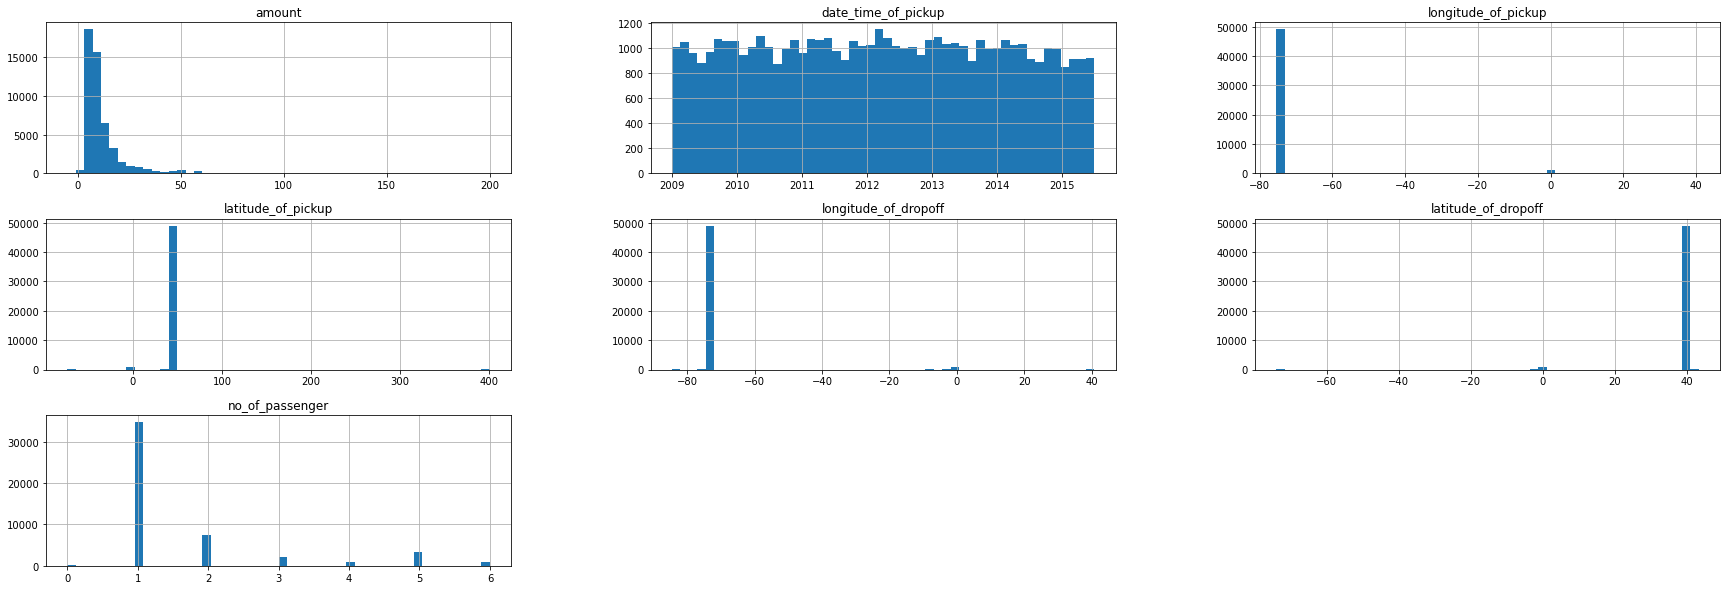

In [13]:
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(30,10))
plt.show()

In [14]:
df.corr().style.background_gradient(cmap="coolwarm")

,amount,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
amount,1.000000,0.005944,-0.007338,0.004286,-0.005442,0.016583
longitude_of_pickup,0.005944,1.000000,-0.950588,0.956131,-0.946968,-0.005604
latitude_of_pickup,-0.007338,-0.950588,1.000000,-0.911123,0.928189,0.003237
longitude_of_dropoff,0.004286,0.956131,-0.911123,1.000000,-0.982117,-0.004936
latitude_of_dropoff,-0.005442,-0.946968,0.928189,-0.982117,1.000000,0.002958
no_of_passenger,0.016583,-0.005604,0.003237,-0.004936,0.002958,1.000000


<AxesSubplot:>

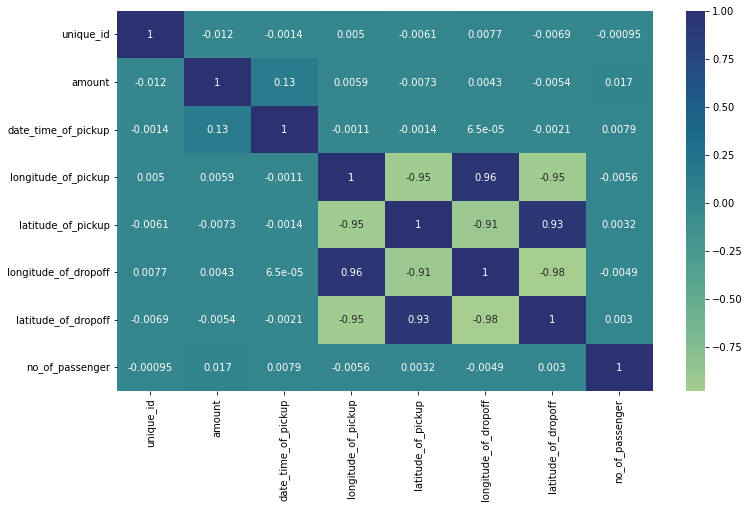

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,7))

sns.heatmap(df.corr(),annot=True,cmap='crest')

In [31]:
#find outliers
df = df.loc[(df.amount >= 2.5)]

In [33]:
print("Remaining observastions in the dataset:", df.shape)

Remaining observastions in the dataset: (49990, 12)


In [34]:
#We will only keep the observation where travel distance is less than or equal to 130
df = df.loc[(df.travel_dist_km >= 1) | (df.travel_dist_km <= 130)]
print("Remaining observastions in the dataset:", df.shape)

Remaining observastions in the dataset: (49990, 12)


In [35]:
#Remove the observations with unreal longitude and latitude values , that is , 90< latitude <-90, 180 < longitude < -180.
incorrect_coordinates = df.loc[(df.latitude_of_pickup > 90) |(df.latitude_of_pickup < -90) |
                                   (df.latitude_of_dropoff > 90) |(df.latitude_of_dropoff < -90) |
                                   (df.longitude_of_pickup > 180) |(df.longitude_of_pickup < -180) |
                                   (df.longitude_of_dropoff > 90) |(df.longitude_of_dropoff < -90)
                                    ].index

In [36]:
df.drop(incorrect_coordinates, inplace = True, errors = 'ignore')

In [38]:
print("Remaining observastions in the dataset:", df.shape)

Remaining observastions in the dataset: (49989, 12)


### countplot to check the peak hours during weekdays

<AxesSubplot:title={'center':'Taxi trips count during week days'}, xlabel='hour', ylabel='count'>

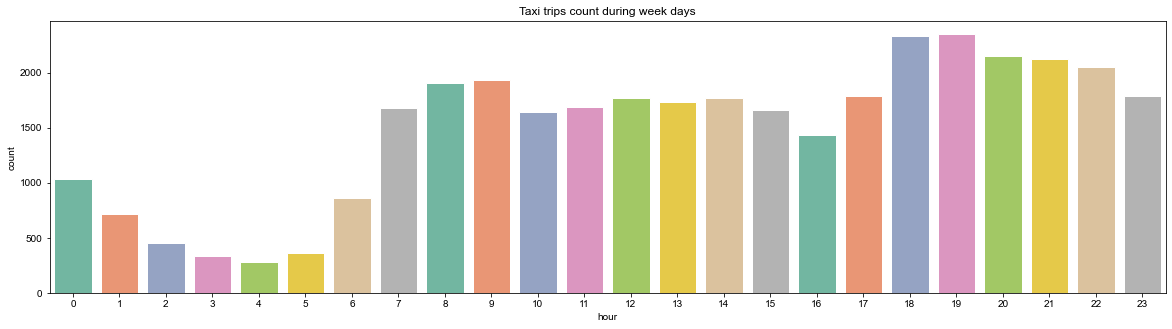

In [39]:
plt.figure(figsize=(20,5))
plt.title('Taxi trips count during week days')
sns.set_style("white")
#plot the countplot for weekdays
sns.countplot(x='hour', data=df.loc[(df.dayofweek >= 0) & (df.dayofweek <=4)], palette='Set2')

### countplot to check the peak hours during weekends

<AxesSubplot:title={'center':'Taxi trips count during week ends'}, xlabel='hour', ylabel='count'>

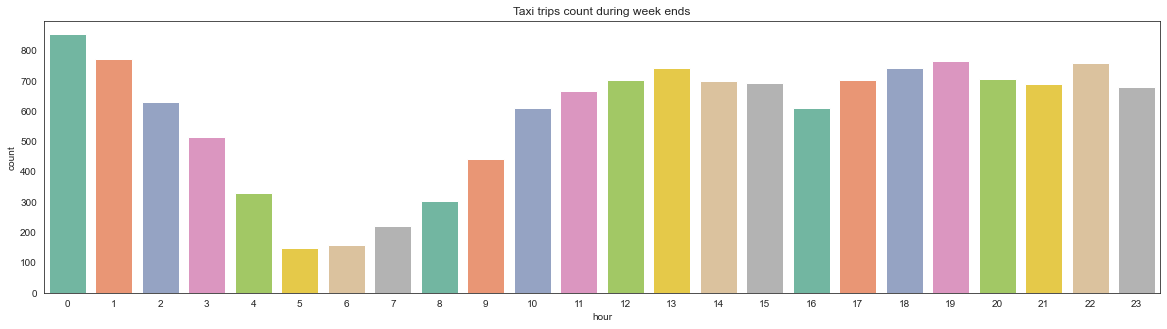

In [41]:
plt.figure(figsize=(20,5))
plt.title('Taxi trips count during week ends')
sns.set_style("white")
#plot the countplot for weekends
sns.countplot(x='hour', data=df.loc[(df.dayofweek >= 5) & (df.dayofweek <=6)], palette='Set2')

In [55]:
x = df.drop('amount',axis = 1)
y = pd.DataFrame(df['amount'])

In [56]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=1)

### Random Forest Model


In [57]:
model = RandomForestRegressor(n_estimators=100, random_state=10)

# fit the regressor with training dataset
model.fit(x_train, y_train)

RandomForestRegressor(random_state=10)

In [58]:
y_pred = model.predict(x_test)

In [59]:
import warnings
warnings.simplefilter("ignore")

In [60]:
# Calculate MSE
rf_reg_MSE = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error (MSE):', rf_reg_MSE)

# Calculate RMSE
rf_reg_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rf_reg_RMSE)

Mean Squared Error (MSE): 19.45643508872385
Root Mean Squared Error (RMSE): 4.4109449201643685


In [61]:
cols = ['Model',  'MSE', 'RMSE']

# create a empty dataframe of the colums
# columns: specifies the columns to be selected
result_tabulation = pd.DataFrame(columns = cols)

# compile the required information
rf_reg_metrics = pd.Series({'Model': "Random Forest ",
                     'MSE': rf_reg_MSE,
                     'RMSE': rf_reg_RMSE     
                   })

# append our result table using append()
# ignore_index=True: does not use the index labels
# python can only append a Series if ignore_index=True or if the Series has a name
result_tabulation = result_tabulation.append(rf_reg_metrics, ignore_index = True)

# print the result table
result_tabulation

,Model,MSE,RMSE
0,Random Forest,19.456435,4.410945
